In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install wandb

In [3]:
!wandb login d0cac647300ba91481111e5fe087ba2c8a2c2992


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
train_data = np.load('/kaggle/input/exo-data/training.npy')
test_data = np.load('/kaggle/input/exo-data/testing.npy')

In [5]:
xt_train = train_data[:,:13]
yt_train = train_data[:,13:14]
xt_test = test_data[:,:13]
yt_test = test_data[:,13:14]

In [6]:
X_train = xt_train
y_train = yt_train
X_test = xt_test
y_test = yt_test

def add_noise(spectra, err, floor=0):
    '''
    Adds the noise specified in err to spectra. The noise needs to be in ppm.
    err can be a float, in which case the same noise will be applied to the whole spectra; an array of the same length as the spectra,
    specifying the noise at each wavelength bin; or a string with the name of a file containing the wavelengths in the first column and the 
    corresponding noise in the second.
    
    A noise floor can be specified (in ppm) in case err does not include it.
    '''
    
    if type(err) == np.ndarray:
        err[err < floor] = floor
        noise = 1e-4*err.reshape(1,-1)*np.random.randn(spectra.shape[0], spectra.shape[1])
        noisy_spec = spectra + noise
        
    elif type(err) == float:
        err = np.max([err, floor])
        noise = 1e-4*err*np.random.randn(spectra.shape[0], spectra.shape[1])
        noisy_spec = spectra + noise
        
    elif type(err) == str:
        err = np.loadtxt(err)[:,1]
        err[err < floor] = floor
        noise = 1e-4*err.reshape(1,-1)*np.random.randn(spectra.shape[0], spectra.shape[1])
        noisy_spec = spectra + noise
    else:
        print('Noise not understood!')
        
    return noisy_spec


In [7]:
#Xn_train= add_noise(X_train, 0.1, floor=0.6)
#Xn_test=add_noise(X_test,0.1,floor=0.6)

wandb: Currently logged in as: planethuntertess11 (ayushgaurav). Use `wandb login --relogin` to force relogin


Epoch 1 loss: 726849.200 R^2: -0.538
Epoch 2 loss: 426588.928 R^2: 0.101
Epoch 3 loss: 422072.654 R^2: 0.111
Epoch 4 loss: 415155.420 R^2: 0.126
Epoch 5 loss: 397119.489 R^2: 0.164
Epoch 6 loss: 321934.995 R^2: 0.321
Epoch 7 loss: 287621.551 R^2: 0.392
Epoch 8 loss: 284799.327 R^2: 0.398
Epoch 9 loss: 283397.282 R^2: 0.402
Epoch 10 loss: 280865.848 R^2: 0.407
Epoch 11 loss: 279761.191 R^2: 0.409
Epoch 12 loss: 277779.446 R^2: 0.414
Epoch 13 loss: 275226.182 R^2: 0.419
Epoch 14 loss: 270711.901 R^2: 0.429
Epoch 15 loss: 262580.809 R^2: 0.446
Epoch 16 loss: 246924.758 R^2: 0.479
Epoch 17 loss: 217740.054 R^2: 0.540
Epoch 18 loss: 190587.318 R^2: 0.597
Epoch 19 loss: 181566.975 R^2: 0.615
Epoch 20 loss: 178553.324 R^2: 0.622
Epoch 21 loss: 178087.606 R^2: 0.624
Epoch 22 loss: 175612.451 R^2: 0.629
Epoch 23 loss: 174752.414 R^2: 0.631
Epoch 24 loss: 172825.259 R^2: 0.634
Epoch 25 loss: 171388.425 R^2: 0.637
Epoch 26 loss: 171341.273 R^2: 0.638
Epoch 27 loss: 170569.325 R^2: 0.639
Epoch 28 

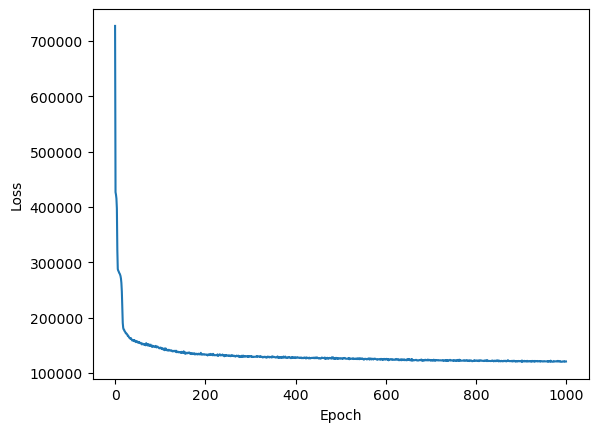

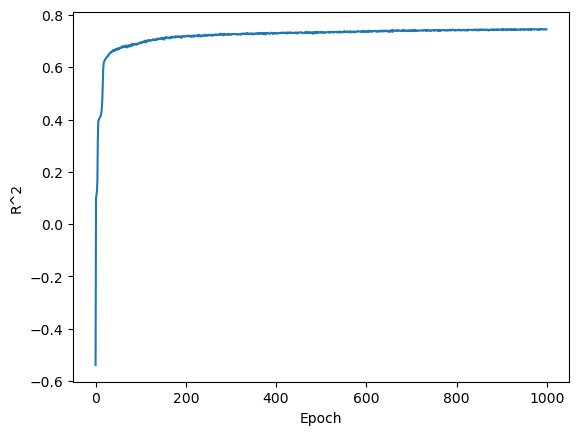

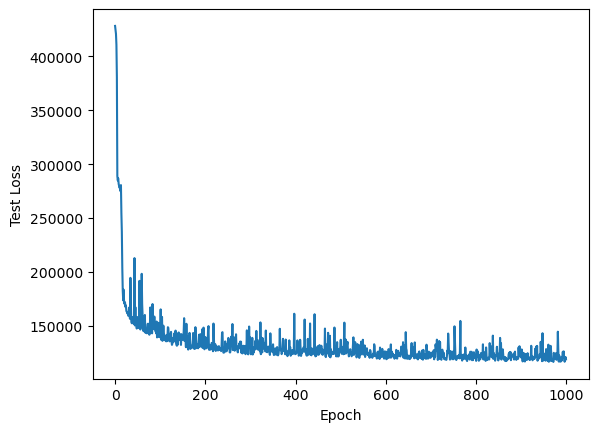

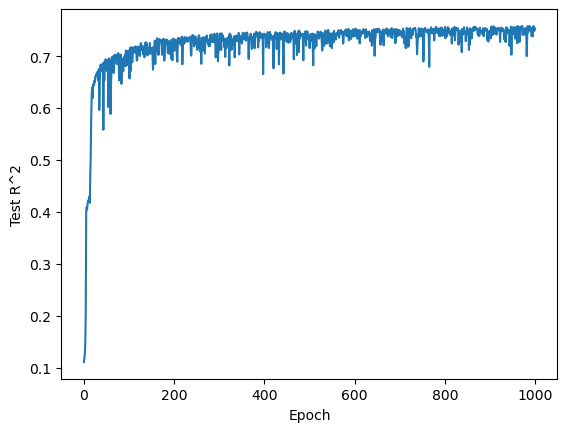

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="nn-project",
    
    # track hyperparameters and run metadata
    config={
    }
)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Define the R^2 loss function
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_pred, y_true):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - ss_res / ss_tot
        return r2

# Define the training function
def train(net, trainloader, criterion, optimizer, epochs, device):
    net.to(device)
    losses = []
    r2s = []
    test_losses = []
    test_r2s = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_r2 = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            r2 = R2Loss()(outputs, labels)
            loss += r2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_r2 += r2.item()
        losses.append(running_loss / len(trainloader))
        r2s.append(running_r2 / len(trainloader))
        print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
        # Test the neural network on the test data
        test_data = X_test
        test_labels = y_test
        test_data = torch.from_numpy(test_data).float()
        test_labels = torch.from_numpy(test_labels).float()
        net.eval()
        with torch.no_grad():
            test_data, test_labels = test_data.to(device), test_labels.to(device)
            test_outputs = net(test_data)
            test_loss = criterion(test_outputs, test_labels)
            test_r2 = R2Loss()(test_outputs, test_labels)
            test_losses.append(test_loss.item())
            test_r2s.append(test_r2.item())
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.plot(r2s)
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.show()
    plt.plot(test_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.show()
    plt.plot(test_r2s)
    plt.xlabel('Epoch')
    plt.ylabel('Test R^2')
    plt.show()

# Define the data
data = X_train 
labels = y_train 

# Convert the data to PyTorch tensors
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

# Define the data loader
trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

# Define the neural network
net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the neural network on GPU
train(net, trainloader, criterion, optimizer, epochs=1000, device=device)

wandb.finish()

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
train_features = train_data[:, :-5]
train_labels = train_data[:, -5:-4]
test_features = test_data[:, :-5]
test_labels = test_data[:, -5:-4]

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

# Predict the labels for the training and testing data
train_predictions = rf.predict(train_features)
test_predictions = rf.predict(test_features)

# Calculate the loss for the training and testing data
train_loss = np.mean((train_predictions - train_labels.values)**2, axis=0)
test_loss = np.mean((test_predictions - test_labels.values)**2, axis=0)

# Calculate the r^2 for the training and testing data
train_r2 = rf.score(train_features, train_labels)
test_r2 = rf.score(test_features, test_labels)

plt.figure()
plt.plot([train_loss[i], test_loss[i]], label='Loss')
plt.plot([train_r2[i], test_r2[i]], label='R^2')
plt.title(f'Label {i+1}')
plt.legend()
plt.show()

import cudf
import cuml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
#train_data = np.load('training.npy')
#test_data = np.load('testing.npy')

# Split the data into features and labels
train_features = train_data[:, :-5].astype(np.float32)
train_labels = train_data[:, -5:-4].astype(np.float32)
test_features = test_data[:, :-5].astype(np.float32)
test_labels = test_data[:, -5:-4].astype(np.float32)

# Convert the data to cuDF format
train_features = cudf.DataFrame.from_pandas(pd.DataFrame(train_features))
train_labels = cudf.DataFrame.from_pandas(pd.DataFrame(train_labels))
test_features = cudf.DataFrame.from_pandas(pd.DataFrame(test_features))
test_labels = cudf.DataFrame.from_pandas(pd.DataFrame(test_labels))

# Train the model
rf = cuml.ensemble.RandomForestRegressor(n_estimators=100, max_depth=16)
rf.fit(train_features, train_labels)

# Predict the labels for the training and testing data
train_predictions = rf.predict(train_features)
test_predictions = rf.predict(test_features)

# Calculate the loss for the training and testing data
train_loss = np.mean((train_predictions - train_labels.values)**2, axis=0)
test_loss = np.mean((test_predictions - test_labels.values)**2, axis=0)

# Calculate the r^2 for the training and testing data
train_r2 = rf.score(train_features, train_labels)
test_r2 = rf.score(test_features, test_labels)

# Plot the loss and r^2 for each label
for i in range(5):
    plt.figure()
    plt.plot([train_loss[i], test_loss[i]], label='Loss')
    plt.plot([train_r2[i], test_r2[i]], label='R^2')
    plt.title(f'Label {i+1}')
    plt.legend()
    plt.show()